# Inversion of total field anomaly data produced by a synthetic cylindrical model

This notebook runs inversion of total field anomaly data using Levenberg-Marquadt's algorithm. The data was generated from a synthetic vbodies data using the poligonal prisms function from fatiando.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle

from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.vis import mpl, myv
from matplotlib import colors, ticker, cm
from IPython.display import Image as img
from matplotlib.mlab import normpdf
from mayavi import mlab
from mayavi.mlab import plot3d

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


### Auxiliary functions

In [2]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing model parameters

In [3]:
with open('../synthetic_data/vbodies/vbodies_model.pickle') as w:
        vbodies_model = pickle.load(w)

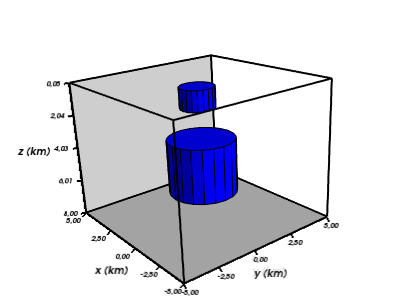

In [4]:
img(filename='../synthetic_data/vbodies/vbodies_true.png')

### Observation points and observed data

In [5]:
with open('../synthetic_data/grids/regular_grid_50x50_10km2.pickle') as w:
        regular_grid = pickle.load(w)

In [6]:
with open('../synthetic_data/vbodies/vbodies_data.pickle') as w:
        vbodies_data = pickle.load(w)

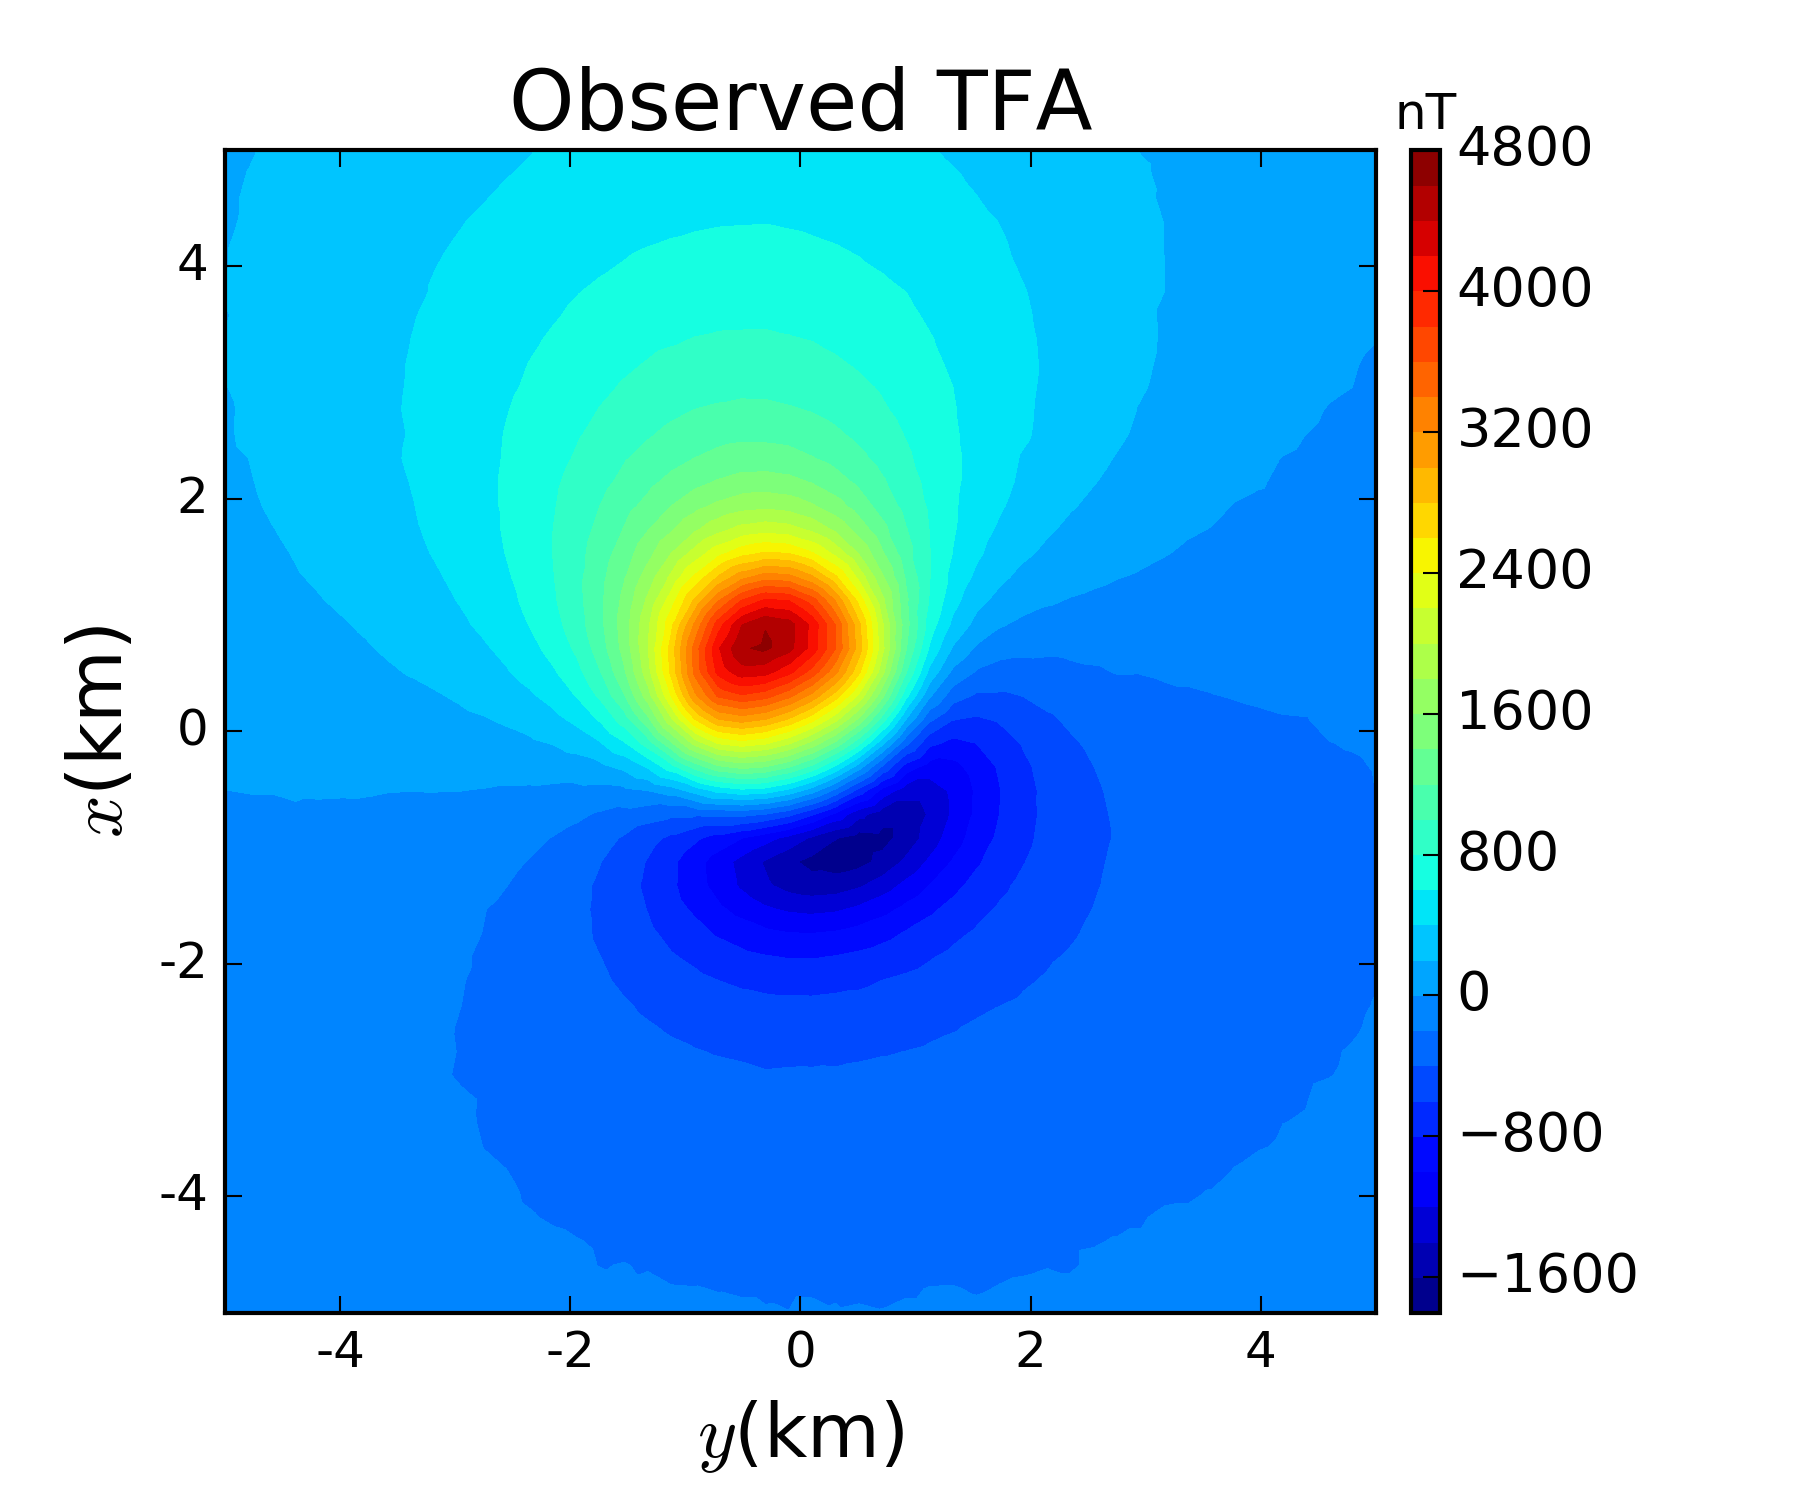

In [7]:
img(filename='../synthetic_data/vbodies/obs_tfa.png', width=400, height=400)

### Parameters for inversion

In [8]:
M = 15 # number of vertices per prism
L = 13 # number of prisms
P = L*(M+2) + 1 # number of parameters

# limits for parameters in meters
rmin = 50.
rmax = 3000.
x0min = -2500.
x0max = 2500.
y0min = -1000.
y0max = 1000.
dzmin = 10.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

itmax = 30
itmax_marq = 15
epsilon = 1.0e-5     # convergence criterion

deltax = 0.01*np.max(x0max)
deltay = 0.01*np.max(y0max)
deltaz = 0.01*np.max(dzmax)
deltar = 0.01*np.max(rmax)# increment of derivatives
m_out = np.zeros(M + 2)  # outcropping body parameters

inc = vbodies_model['inc']
dec = vbodies_model['dec']
z0 = vbodies_model['z0']
dz = 550.
props = vbodies_model['props']
dobs = vbodies_data['tfa_obs']
x = regular_grid['x']
y = regular_grid['y']
z = regular_grid['z']
N = regular_grid['x'].size

#rin = np.linspace(500.,501.,M)
rin = np.zeros(M) + 1000.
m0 = np.hstack((rin, np.zeros(2)))
m0 = np.resize(m0, P-1) # inicial parameters vector
m0 = np.hstack((m0, dz))
model0 = mfun.param2polyprism(m0, M, L, z0, props) # list of classes of prisms
d0 = polyprism.tf(x, y, z, model0, inc, dec) # predict data
res0 = dobs - d0

### Plotting the source and intial estimate

In [9]:
bounds = [-5000., 5000., -5000., 5000., 50., 10000.]

red, green, blue = (1, 0, 0), (0, 1, 0), (0, 0, 1)
white, black = (1, 1, 1), (0, 0, 0),

# Show the model
scene = myv.figure()
true = myv.polyprisms(vbodies_model['prisms'], 'magnetization', opacity=1., color=blue)
myv.polyprisms(model0, 'magnetization', opacity=.5, color=red)

ax = myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.font_factor = 1.65
scene.scene.camera.position = [-0.089204656936016313, -0.066107174155361687, -0.04083578885723696]
scene.scene.camera.focal_point = [1.1820671636724554e-16, 1.3134079596360617e-17, -1.9701119394540926e-17]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.24683390337942718, 0.24593292331329802, -0.93733132955911114]
scene.scene.camera.clipping_range = [0.057117737884348194, 0.1956040854922288]
scene.scene.camera.compute_view_plane_normal()

myv.wall_bottom(ax.axes.bounds, opacity=0.2)
myv.wall_north(ax.axes.bounds)

myv.savefig('figs/vbodies_tfa_true_initial.png')
myv.show()

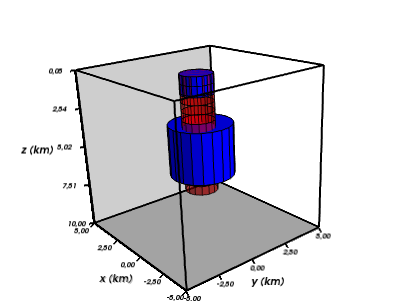

In [10]:
img(filename='figs/vbodies_tfa_true_initial.png')

### Observed TFA with initial estimate

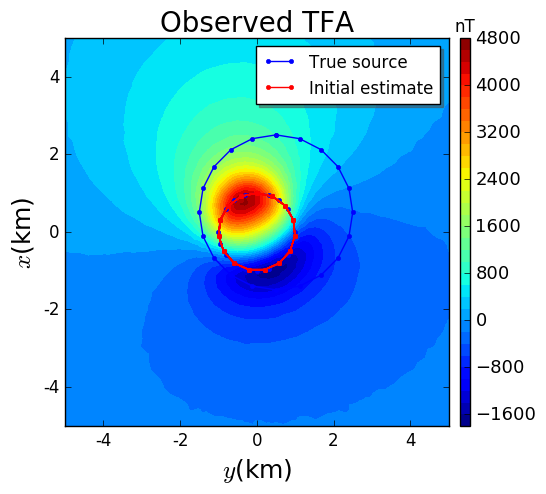

In [11]:
plt.figure(figsize=(6,5))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(regular_grid['y'], regular_grid['x'], vbodies_data['tfa_obs'], 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
plt.ylim((np.min(regular_grid['x']), np.max(regular_grid['x'])))
plt.xlim((np.min(regular_grid['y']), np.max(regular_grid['y'])))
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
for p in vbodies_model['prisms']:
    source = mpl.polygon(p, '.-b', xy2ne=True)
for p in model0:
    estimate = mpl.polygon(p, '.-r', xy2ne=True)
source.set_label('True source')
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
plt.savefig('figs/vbodies_tfa_obs_data_true_inital.png', dpi=300)
plt.show()

### Regularization parameters

In [12]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 1000.
dlamb = 10.      # step for Marquadt's parameter

a1 = 0.0001  # adjacent radial distances within each prism
a2 = 0.0001   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 0.0001     # vertically adjacent origins
a6 = 0.00001   # zero order Tikhonov on adjacent radial distances
a7 = 0.1    # zero order Tikhonov on thickness of each prism

In [13]:
delta = np.array([deltax, deltay, deltar, deltaz])
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

### Inversion

In [14]:
d_fit, m_est, model_est, phi_list = mfun.levmarq_tf(x, y, z, m0, M, L, delta, itmax,
                                                    itmax_marq, lamb, dlamb, epsilon,
                                                    mmin, mmax, m_out, dobs, inc, dec,
                                                    props, alpha, z0, dz)

it:  0   it_marq:  0   lambda: 1e+03   misfit: 1.83385e+04
it:  1   it_marq:  0   lambda: 1e+02   misfit: 1.51493e+04
it:  2   it_marq:  0   lambda: 1e+01   misfit: 3.60674e+03
it:  3   it_marq:  0   lambda: 1e+00   misfit: 6.60088e+02
it:  4   it_marq:  0   lambda: 1e-01   misfit: 4.47339e+02
it:  5   it_marq:  0   lambda: 1e-02   misfit: 3.87904e+02
it:  6   it_marq:  0   lambda: 1e-03   misfit: 4.35226e+02
it:  6   it_marq:  1   lambda: 1e-02   misfit: 3.70274e+02
it:  7   it_marq:  0   lambda: 1e-03   misfit: 4.03872e+02
it:  7   it_marq:  1   lambda: 1e-02   misfit: 3.73350e+02
it:  7   it_marq:  2   lambda: 1e-01   misfit: 3.46192e+02
it:  8   it_marq:  0   lambda: 1e-02   misfit: 3.65168e+02
it:  8   it_marq:  1   lambda: 1e-01   misfit: 3.42237e+02
it:  9   it_marq:  0   lambda: 1e-02   misfit: 3.65749e+02
it:  9   it_marq:  1   lambda: 1e-01   misfit: 3.44445e+02
it:  9   it_marq:  2   lambda: 1e+00   misfit: 3.40126e+02
it: 10   it_marq:  0   lambda: 1e-01   misfit: 3.44151e+

# Results

In [15]:
res = dobs - d_fit

In [16]:
plt.figure(figsize=(6,5))
plt.title("Residual data", fontsize = 18)
plt.axis('scaled')
nlevels = mpl.contourf(y, x, res, regular_grid['shape'], 20, cmap='jet')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
plt.ylim((np.min(regular_grid['x']), np.max(regular_grid['x'])))
plt.xlim((np.min(regular_grid['y']), np.max(regular_grid['y'])))
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.set_title('nT')
#plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1
mpl.m2km()
plt.savefig('figs/vbodies_tfa_td_fit.png', dpi=300)
#plt.show()

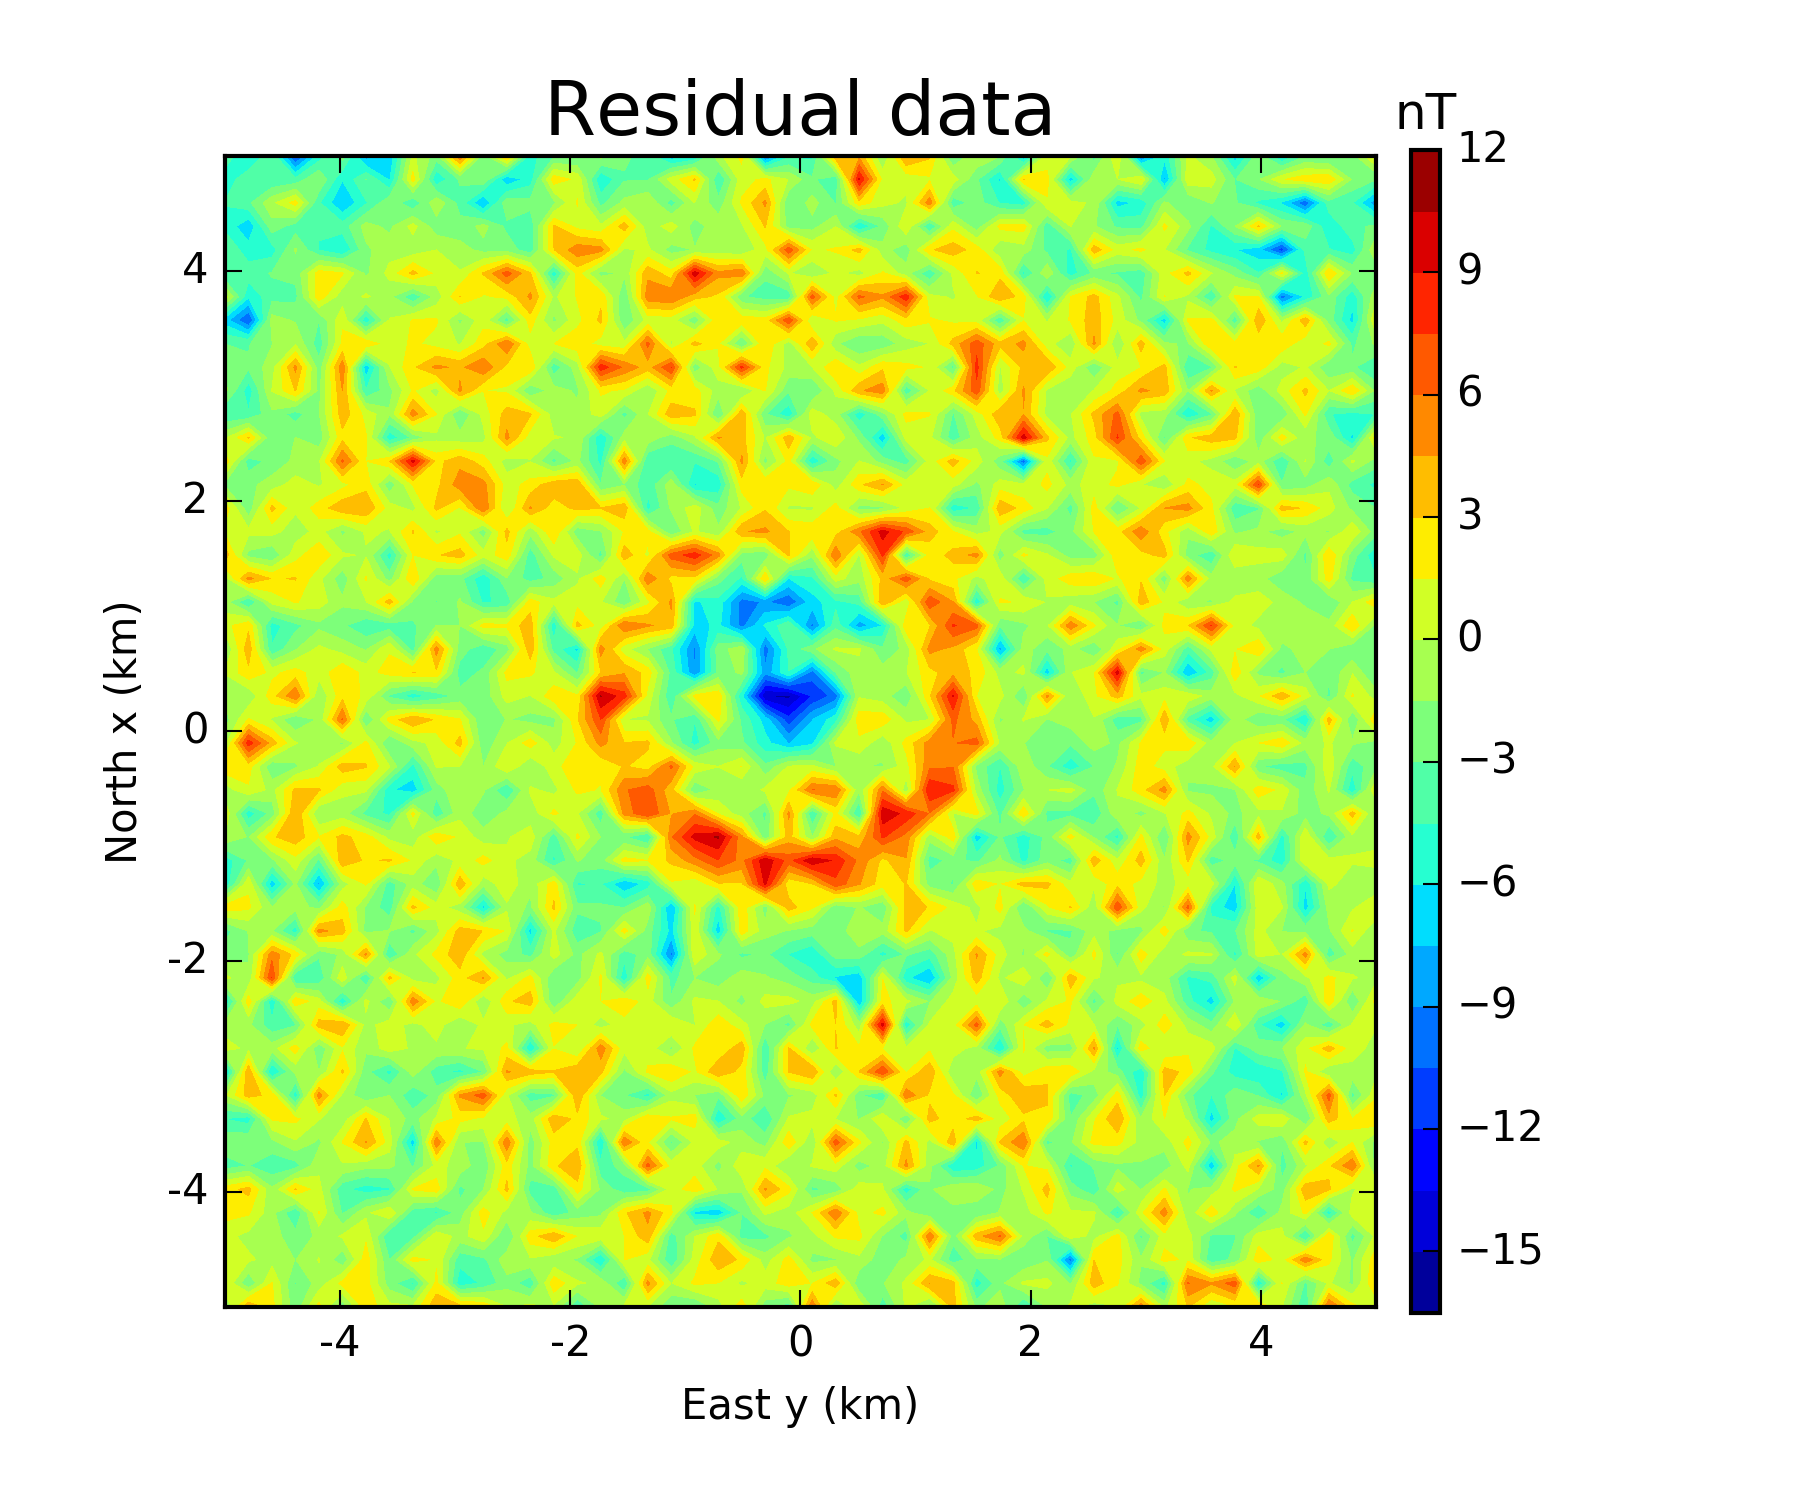

In [17]:
img(filename='figs/vbodies_tfa_td_fit.png', width=400, height=400)

In [18]:
plt.figure(figsize=(6,5))
plt.title('Histogram', fontsize = 20)
plt.xlabel('$\mu$ = %.7f  $\sigma$ = %.7f' % (np.mean(res), np.std(res)), fontsize=20)
nbins = 20
n, bins, patches = plt.hist(res,bins=nbins, normed=True, color='blue')
gauss = normpdf(bins, np.mean(res), np.std(res))
plt.plot(bins, gauss, 'k--', linewidth=2., label='Gaussian')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
plt.savefig('figs/vbodies_tfa_td_hist.png', dpi=300)
#plt.show()

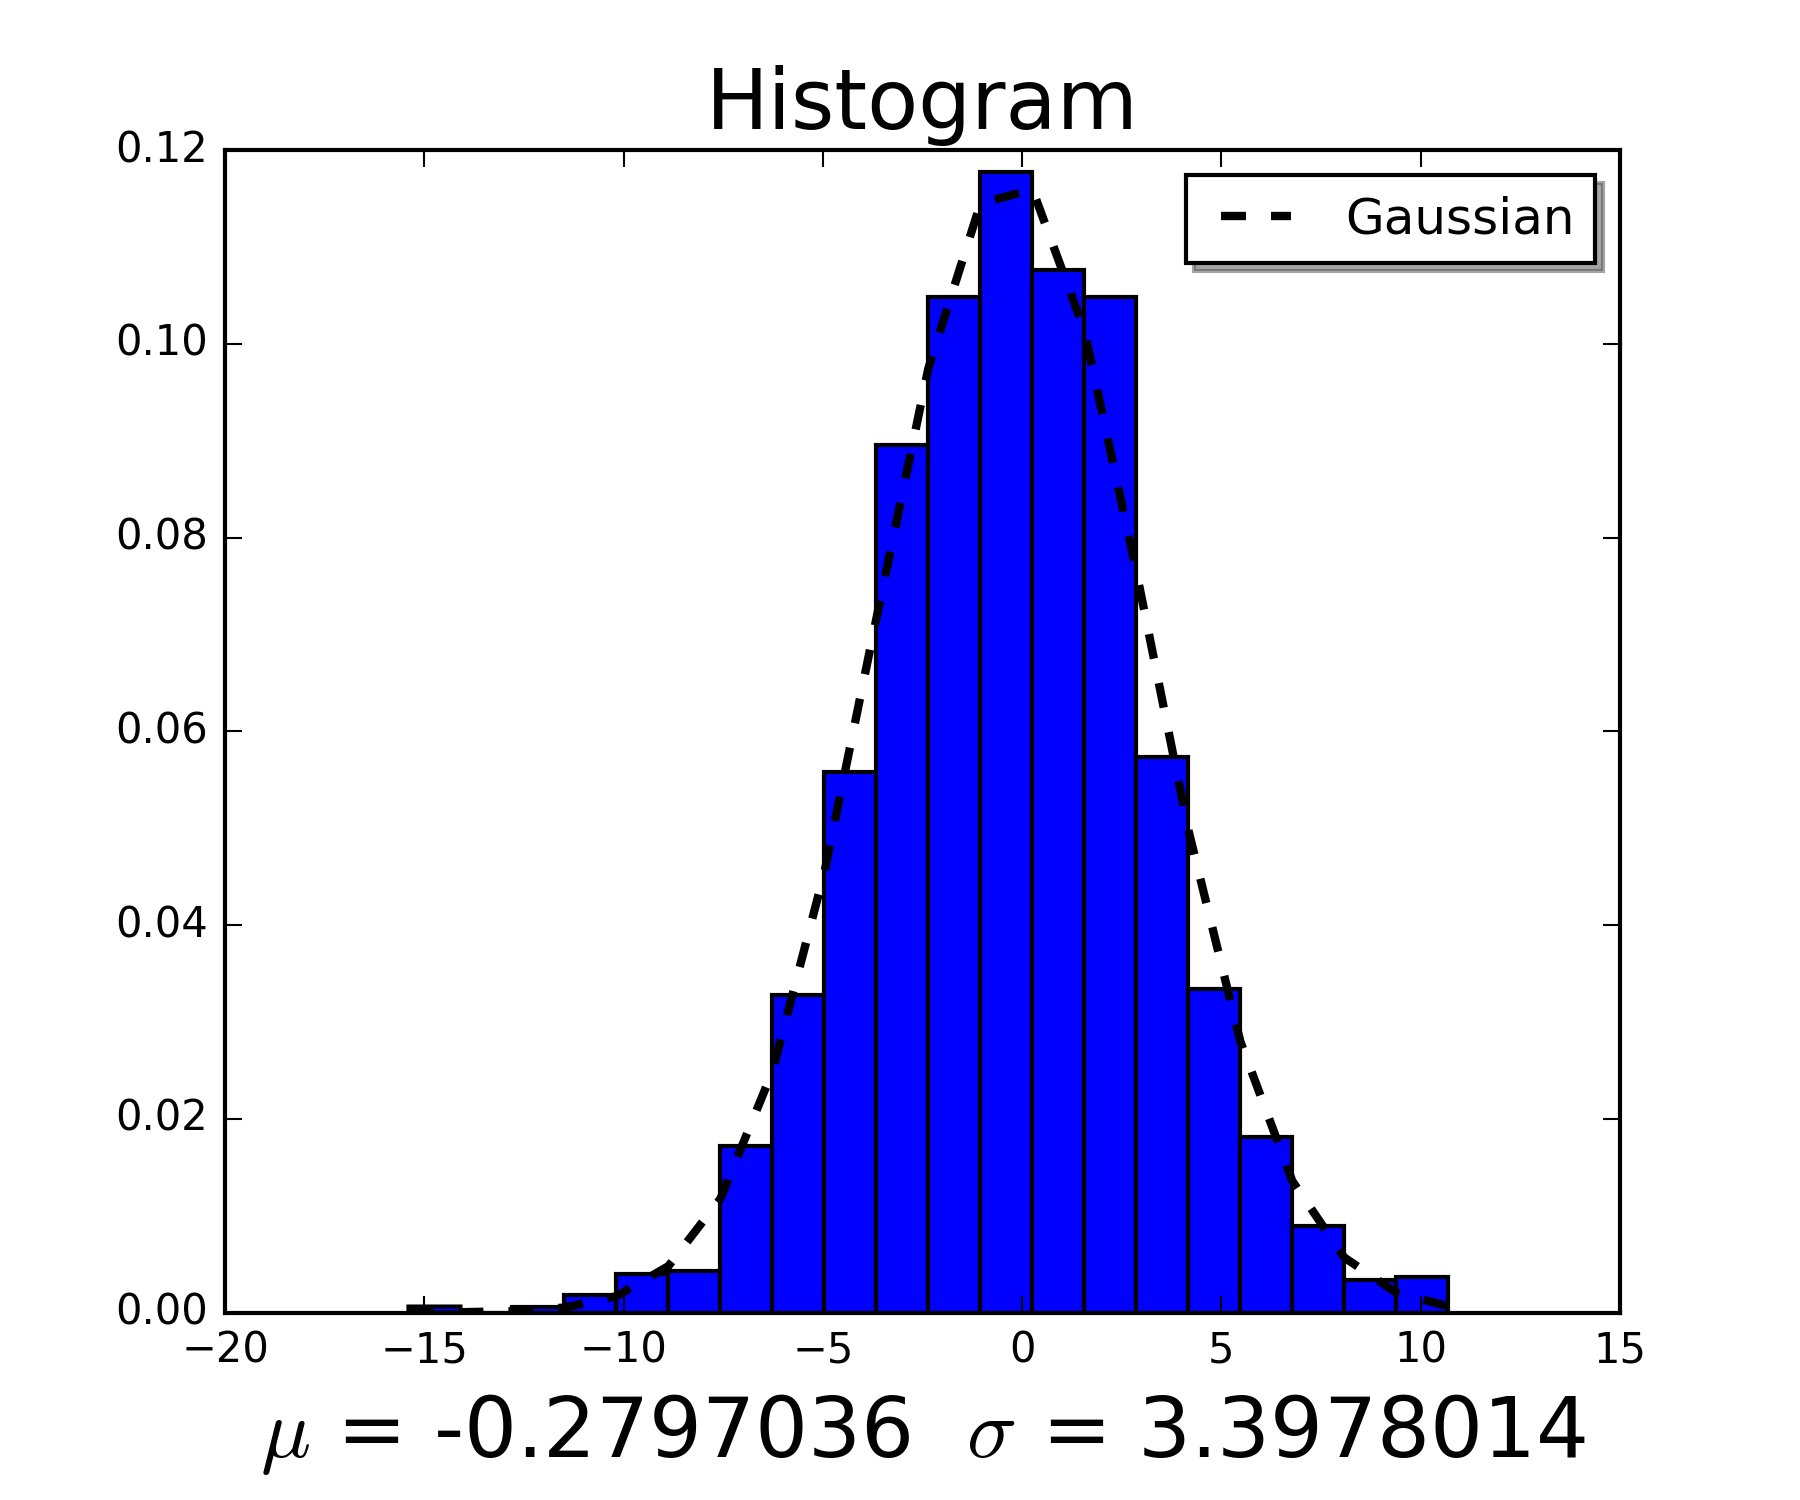

In [19]:
img(filename='figs/vbodies_tfa_td_hist.png', width=400, height=400)

In [20]:
plt.figure(figsize=(6,5))
plt.title('Convergence', fontsize = 18)
plt.xlabel('Iteration number')
plt.plot(phi_list, 'b-', label='Misfit value')
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)

plt.savefig('figs/vbodies_tfa_td_convergence.png', dpi=300)
#plt.show()

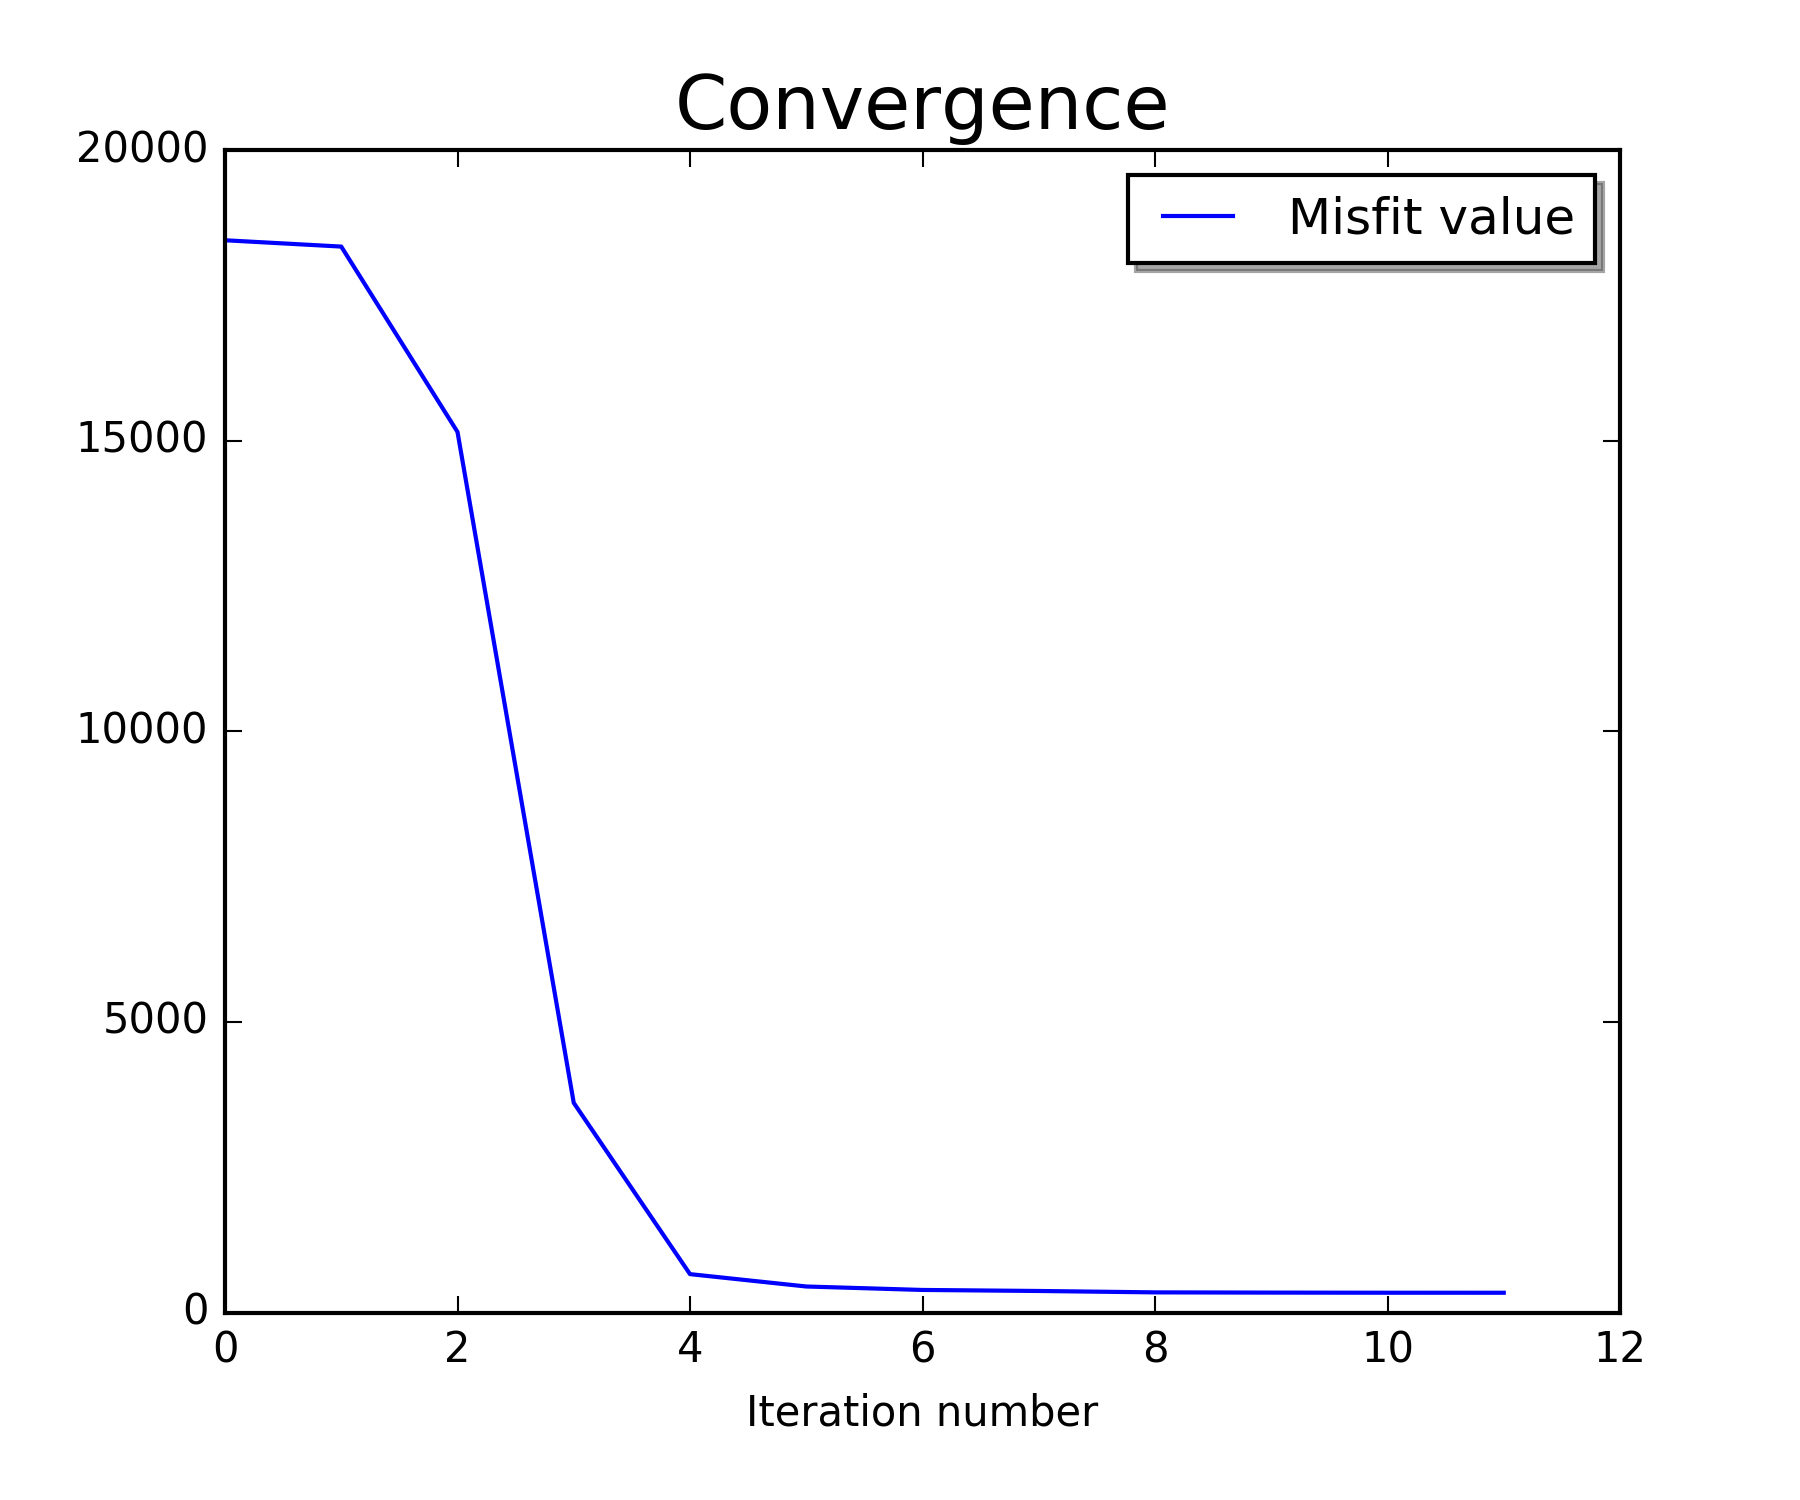

In [21]:
img(filename='figs/vbodies_tfa_td_convergence.png', width=400, height=400)

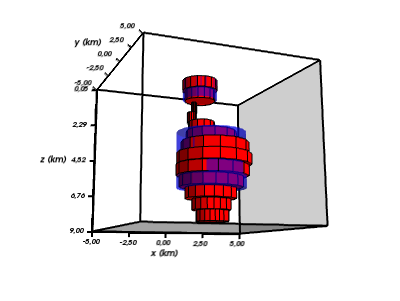

In [22]:
bounds = [-5000., 5000., -5000., 5000., 50., 9000.]

red, green, blue = (1, 0, 0), (0, 1, 0), (0, 0, 1)
white, black = (1, 1, 1), (0, 0, 0),

# Show the model
scene = myv.figure()
myv.polyprisms(vbodies_model['prisms'], 'magnetization', color=blue, linewidth=1., opacity=.5, edges=False)
myv.polyprisms(model_est, 'magnetization', color=red, linewidth=1.)


ax = myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.font_factor = 1.5
scene.scene.camera.position = [-0.089204656936016313, -0.066107174155361687, -0.04083578885723696]
scene.scene.camera.focal_point = [1.1820671636724554e-16, 1.3134079596360617e-17, -1.9701119394540926e-17]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.24683390337942718, 0.24593292331329802, -0.93733132955911114]
scene.scene.camera.clipping_range = [0.057117737884348194, 0.1956040854922288]
scene.scene.camera.compute_view_plane_normal()

myv.wall_bottom(ax.axes.bounds, opacity=0.2)
myv.wall_north(ax.axes.bounds)
#myv.title('bolacha', color=(0, 0, 0), size=1.3, height=0.5)
myv.savefig('figs/vbodies_tfa_td_bolacha1.png')
myv.show()

img(filename='figs/vbodies_tfa_td_bolacha1.png')

# Show the model
scene = myv.figure()
myv.polyprisms(vbodies_model['prisms'], 'magnetization', color=blue, linewidth=1., opacity=.5, edges=False)
myv.polyprisms(model_est, 'magnetization', color=red, linewidth=1.)


ax = myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.font_factor = 1.5
scene.scene.camera.position = [1387.431758173668, 3940.587088035918, -711.23575855995603]
scene.scene.camera.focal_point = [-1.9226665366075403e-12, -3.8453330732150806e-12, 425.00000000000171]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [-0.053368194299606389, -0.25926638141600067, -0.96433022316250794]
scene.scene.camera.clipping_range = [2297.6930207290479, 6897.4792769581109]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()

myv.wall_bottom(ax.axes.bounds, opacity=0.2)
myv.wall_north(ax.axes.bounds)
#myv.title('bolacha', color=(0, 0, 0), size=1.3, height=0.5)
myv.savefig('figs/vbodies_tfa_td_bolacha2.png')
myv.show()

img(filename='figs/vbodies_tfa_td_bolacha2.png')

# Show the model
scene = myv.figure()
myv.polyprisms(vbodies_model['prisms'], 'magnetization', color=blue, linewidth=1., opacity=.5, edges=False)
myv.polyprisms(model_est, 'magnetization', color=red, linewidth=1.)


ax = myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.font_factor = 1.5
scene.scene.camera.position = [-312.73912567501554, -3561.7262362085721, 287.67386774078057]
scene.scene.camera.focal_point = [1.9226665366075399e-12, -2.4033331707594249e-12, 425.00000000000017]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.13341196746632145, 0.026483446094695474, -0.99070675480674641]
scene.scene.camera.clipping_range = [1993.7950353893316, 5580.9677877221075]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()

myv.wall_bottom(ax.axes.bounds, opacity=0.2)
myv.wall_north(ax.axes.bounds)
#myv.title('bolacha', color=(0, 0, 0), size=1.3, height=0.5)
myv.savefig('figs/vbodies_tfa_td_bolacha3.png')
myv.show()

img(filename='figs/vbodies_tfa_td_bolacha3.png')

# Show the model
scene = myv.figure()
myv.polyprisms(vbodies_model['prisms'], 'magnetization', color=blue, linewidth=1., opacity=.5, edges=False)
myv.polyprisms(model_est, 'magnetization', color=red, linewidth=1.)


ax = myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.font_factor = 1.5
scene.scene.camera.position = [-1358.4495936442941, 3241.6425529534445, 1095.0196037678566]
scene.scene.camera.focal_point = [1.1115415914762344e-12, 4.8066663415188518e-13, 424.99999999999943]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [-0.069838400113651236, 0.17376780317072943, -0.98230715585848405]
scene.scene.camera.clipping_range = [1555.7568575367334, 6132.3676045661978]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()

myv.wall_bottom(ax.axes.bounds, opacity=0.2)
myv.wall_north(ax.axes.bounds)
#myv.title('bolacha', color=(0, 0, 0), size=1.3, height=0.5)
myv.savefig('figs/vbodies_tfa_td_bolacha4.png')
myv.show()

img(filename='figs/vbodies_tfa_td_bolacha4.png')